In [2]:
SCRIPT_DIR = os.path.dirname('../src/')
sys.path.append(os.path.dirname(SCRIPT_DIR))

In [5]:
import warnings
import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import  class_weight

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from src.wrapped import Wrapped

In [6]:
warnings.filterwarnings("ignore")

wp = Wrapped(
    '../data/row/',
    '../data/processed/',
    '../data/files/'
)

# Importando dados para treinamento

In [7]:
df = wp.load_data('df_instrumentos_features_selecionadas')
df

,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,chroma8,chroma9,chroma10,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,file_name
0,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,0.660767,0.349147,0.252198,...,3409.640722,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,000139_119040.ogg
1,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,0.321750,0.299794,0.450477,...,3516.595715,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,000145_172800.ogg
2,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,0.333150,0.089059,0.103378,...,3256.491175,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,000201_168960.ogg
3,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,0.381560,0.275192,0.380790,...,3855.791675,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,000212_211200.ogg
4,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,0.309727,0.388397,0.299227,...,2883.225952,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,000640_49920.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8471,0.332754,0.359639,0.473210,0.512169,0.607755,0.500391,0.378782,0.420053,0.423016,0.570144,...,3664.812127,3194.922838,1.253166,6714.437434,-53.587788,-76.614616,0.134979,29855,voice,153341_184320.ogg
8472,0.161793,0.190661,0.249882,0.378161,0.461520,0.332309,0.294171,0.251455,0.106215,0.089914,...,2879.597305,1351.326334,1.450944,2412.643029,-52.071827,-76.029976,0.061211,13533,voice,153412_134400.ogg
8473,0.589552,0.309548,0.187583,0.169132,0.240637,0.332375,0.333517,0.585136,0.280368,0.236353,...,3274.875402,2685.831528,1.274003,4614.225695,-66.120743,-80.000000,0.157649,34869,voice,153478_30720.ogg
8474,0.615495,0.541314,0.467334,0.611199,0.791296,0.678383,0.508162,0.543337,0.463837,0.352893,...,3376.494191,1428.726581,1.081204,3358.205447,-30.260586,-13.068514,0.032283,7136,voice,153986_203520.ogg


- Algumas informações

In [8]:
print('Dimensões do dataframe', df.shape)
print('Total de instrumentos na base original:', len(df.instrumento.unique()))
df.instrumento.value_counts()

Dimensões do dataframe (8476, 32)
Total de instrumentos na base original: 20


mallet_percussion    719
flute                654
piano                628
organ                611
saxophone            539
accordion            511
bass                 508
cymbals              503
cello                481
violin               469
voice                452
ukulele              389
banjo                375
synthesizer          375
guitar               347
drums                336
trombone             196
mandolin             163
clarinet             152
trumpet               68
Name: instrumento, dtype: int64

# Preprocessamento

In [9]:
le = LabelEncoder()

df['labels'] = le.fit_transform(df.instrumento)

# Split

In [10]:
X = df.drop(columns=['labels', 'instrumento','file_name'])
y = df['labels']

# TESTE 1: Balanceamento

- 1° Opção: Balanceamento das classes com SMOTH

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
sm = SMOTE()
X_train, y_train  = sm.fit_resample(X_train, y_train)

In [ ]:
models = np.array([KNeighborsClassifier(),
                   DecisionTreeClassifier(), 
                   RandomForestClassifier(), 
                   LGBMClassifier(),MLPClassifier()])

In [ ]:
for model in models:
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    print(f'Acuracia {model}: {accuracy_score(y_test, predict).round(2) * 100}%')
    

Acuracia KNeighborsClassifier(): 12.0%
Acuracia DecisionTreeClassifier(): 16.0%
Acuracia RandomForestClassifier(): 31.0%
Acuracia LGBMClassifier(): 33.0%
Acuracia MLPClassifier(): 15.0%


- Class Weight

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
#  Calculate weights using sklearn
sklearn_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

sklearn_weights

array([0.88552239, 1.1498062 , 0.81497253, 0.93876582, 2.74675926,
       0.82402778, 1.22078189, 0.66364653, 1.10690299, 0.60417515,
       2.53547009, 0.67883295, 0.66069042, 0.77454308, 1.15878906,
       2.04586207, 5.70480769, 1.13659004, 0.88817365, 0.96003236])

In [ ]:
models = np.array([
    KNeighborsClassifier(),
    DecisionTreeClassifier(class_weight= 'balanced'), 
    RandomForestClassifier(class_weight = 'balanced', random_state = 0, n_jobs = -1), 
    LogisticRegression(class_weight = 'balanced', random_state = 0, n_jobs = -1), 
    LGBMClassifier(class_weight= 'balanced'),
    MLPClassifier()
])


for model in models:
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    print(f'Acuracia {model}: {accuracy_score(y_test, predict).round(2) * 100}%')

Acuracia KNeighborsClassifier(): 15.0%
Acuracia DecisionTreeClassifier(class_weight='balanced'): 17.0%
Acuracia RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0): 33.0%


/home/douglas/projetos/pessoal/detected_instruments/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acuracia LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=0): 17.0%
Acuracia LGBMClassifier(class_weight='balanced'): 34.0%
Acuracia MLPClassifier(): 17.0%


# TESTE 2: Clustering

- Encontrar o numero ideal de cluster

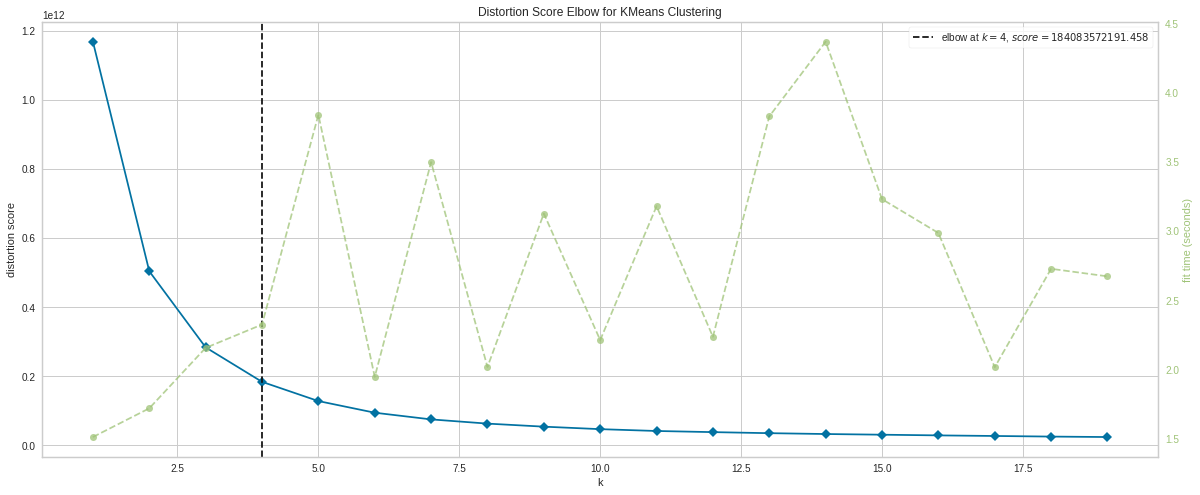

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
model = KMeans()
plt.figure(figsize=( 20, 8 ))
visualizer = KElbowVisualizer(model, k=(1, 20))

visualizer.fit(df.drop(columns=['instrumento', 'file_name']))
visualizer.show()

- Treinando o K-means

In [21]:
k_means = KMeans(n_clusters = 4, random_state = 0)
labels = k_means.fit_predict(df.drop(columns=['instrumento', 'file_name']))

df['clusters'] = labels

- Plotando resultados